In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

In [46]:
# arguments for training
args = {'lr':0.005,
        'epochs':5000, # layer 1 and 11 improve with 5000+ epochs but runs super slow
        'noise':0.01,
        'train size':1800,
        'spec scale':10**12,
        'loss function':nn.L1Loss(),
        'optimizer function': torch.optim.Adam
        }

num_layers = 11

In [47]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Preparing Data

In [48]:
df = pd.read_excel('wide_range.xlsx')
df

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,...,7.55e-06,7.6e-06,7.65e-06,7.7e-06,7.75e-06,7.8e-06,7.85e-06,7.9e-06,7.95e-06,8e-06
0,364.787366,317.684838,313.810126,303.307879,314.323118,317.828320,318.557698,308.808121,309.953331,296.299100,...,2.291410e-12,2.333930e-12,2.371461e-12,2.402093e-12,2.424702e-12,2.433566e-12,2.417632e-12,2.365972e-12,2.285583e-12,2.211520e-12
1,342.552920,335.048875,325.169322,323.807685,312.667938,307.509532,318.808960,312.412740,305.472749,315.420270,...,1.639899e-12,1.669825e-12,1.698490e-12,1.723560e-12,1.743375e-12,1.753393e-12,1.745497e-12,1.711668e-12,1.656824e-12,1.606307e-12
2,314.150653,325.319947,330.529579,337.855852,336.525836,349.311552,336.370506,342.758437,344.195955,333.964029,...,4.487510e-12,4.550427e-12,4.603621e-12,4.643395e-12,4.667637e-12,4.665521e-12,4.616247e-12,4.499595e-12,4.329608e-12,4.173042e-12
3,302.513193,306.523372,315.214925,315.629483,313.136991,312.378427,319.314782,302.018575,306.730069,310.949569,...,2.760638e-12,2.807683e-12,2.849087e-12,2.882405e-12,2.906159e-12,2.913462e-12,2.891133e-12,2.826217e-12,2.727201e-12,2.635977e-12
4,332.142887,315.836569,320.947657,325.884656,338.307720,339.673089,334.705064,325.483513,321.166972,307.175291,...,3.121194e-12,3.173340e-12,3.218273e-12,3.253581e-12,3.277914e-12,3.283670e-12,3.256076e-12,3.180625e-12,3.066965e-12,2.962253e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,335.977302,330.241682,343.703154,340.218015,330.146201,328.147822,327.013308,324.117365,328.765182,349.809711,...,3.492639e-12,3.541544e-12,3.586094e-12,3.622037e-12,3.646522e-12,3.650482e-12,3.617422e-12,3.531303e-12,3.402929e-12,3.284666e-12
2196,295.379242,293.251102,296.318163,309.705578,316.303984,321.883308,335.052888,332.051792,332.335927,338.805641,...,4.885042e-12,4.950908e-12,5.006120e-12,5.046707e-12,5.070411e-12,5.065506e-12,5.009465e-12,4.880432e-12,4.693737e-12,4.521797e-12
2197,302.147937,330.381158,325.654767,339.596050,340.118082,331.556311,345.541835,346.354970,336.491525,344.553594,...,2.505269e-12,2.542833e-12,2.578975e-12,2.609906e-12,2.632938e-12,2.641187e-12,2.622551e-12,2.565215e-12,2.476821e-12,2.395382e-12
2198,291.079250,297.187368,316.074457,317.549974,316.173049,333.928034,328.743984,333.894228,331.093773,324.365239,...,1.138944e-12,1.158522e-12,1.179434e-12,1.199129e-12,1.215649e-12,1.225428e-12,1.222663e-12,1.201639e-12,1.165695e-12,1.132607e-12


In [49]:
# first columns of excel sheet is temperature data, then spectral data
y = df.iloc[:,:num_layers]
X = df.iloc[:,num_layers:]

# scale the spectral data appropriately
X = X.apply(lambda x: x*args['spec scale'])

clean_X = X.copy() # data with no noise

# add noise to other X data
noise = np.random.normal(loc=0, scale=args['noise'], size=X.shape)
X = X + noise

# split the data for training and testing
X_train = X.iloc[:args['train size'], :]
clean_X_train = clean_X.iloc[:args['train size'], :]
y_train = y.iloc[:args['train size'], :]

X_test = X.iloc[args['train size']:, :]
clean_X_test = clean_X.iloc[args['train size']:, :]
y_test = y.iloc[args['train size']:, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

# index the data
X_train.index = range(len(X_train))
X_test.index = range(len(X_test))
clean_X.index = range(len(clean_X))

In [50]:
# more training data
# less testing data
clean_X_train

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.058092,0.050960,0.067645,0.053079,0.073458,0.070581,0.109244,0.088127,0.132571,0.171505,...,5.559207,5.624286,5.680092,5.720913,5.743184,5.733194,5.665447,5.515370,5.300453,5.102552
1796,0.020865,0.017815,0.022672,0.017545,0.024215,0.023642,0.038249,0.033440,0.052788,0.071098,...,2.731465,2.776065,2.816257,2.849120,2.872770,2.880196,2.858326,2.794344,2.696633,2.606612
1797,0.023957,0.022099,0.031060,0.025120,0.035467,0.034308,0.052319,0.040247,0.059008,0.074613,...,1.257615,1.280629,1.303892,1.325103,1.342545,1.352494,1.348604,1.324601,1.284201,1.247003
1798,0.038770,0.035673,0.050047,0.040308,0.056641,0.054457,0.082382,0.062676,0.091149,0.114388,...,2.320425,2.355479,2.389728,2.419447,2.441954,2.450765,2.434611,2.382484,2.301435,2.226764


In [51]:
X_train

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.037769,0.024759,0.044820,0.043365,0.046712,0.061389,0.070518,0.081319,0.078533,0.120251,...,5.014035,5.099623,5.149185,5.182471,5.196867,5.205868,5.154261,5.029524,4.819866,4.658605
1,0.014528,0.014584,0.016157,0.018787,0.024101,0.017500,0.033474,0.036915,0.059737,0.072027,...,1.222950,1.239467,1.270249,1.298194,1.312892,1.326697,1.338433,1.280705,1.251770,1.224198
2,0.035963,0.008197,0.013651,0.014740,0.034236,0.029475,0.031207,0.023675,0.060967,0.103008,...,3.831887,3.878242,3.936707,3.976348,3.985602,3.990230,3.971389,3.865483,3.704669,3.574604
3,0.021911,-0.007524,0.039721,0.006462,0.021349,0.022399,0.027331,0.025699,0.054982,0.055884,...,4.835165,4.900406,4.943351,4.990676,5.009345,5.033068,4.943062,4.860090,4.638143,4.479290
4,0.028990,0.001483,0.034934,0.026549,0.027775,0.024492,0.020150,0.020221,0.036349,0.053278,...,4.023172,4.095304,4.166588,4.193672,4.207342,4.204637,4.150850,4.070719,3.911599,3.796078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,0.001014,0.010957,-0.005794,0.004667,-0.002302,0.017447,0.029345,0.019594,0.019977,0.030272,...,1.725988,1.747309,1.797696,1.811454,1.846211,1.858892,1.825211,1.825495,1.754985,1.689996
1796,0.015073,0.026307,0.028290,0.014983,0.017801,0.028448,0.042129,0.042676,0.048654,0.091871,...,1.869964,1.910731,1.940656,1.973803,1.994617,2.005199,1.970237,1.944504,1.870923,1.836983
1797,0.070618,0.023675,0.067228,0.044161,0.071767,0.071199,0.104003,0.073541,0.120110,0.152570,...,5.341782,5.410975,5.465835,5.521679,5.536216,5.515273,5.457544,5.308818,5.100857,4.932042
1798,0.036049,0.005878,0.016964,0.010572,0.034561,0.020774,0.022798,0.025886,0.036396,0.044552,...,2.575413,2.613782,2.647365,2.669976,2.707338,2.727856,2.697364,2.633887,2.563412,2.462927


# Creating and Training AE

In [52]:
# define AE
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size):
        super(Autoencoder, self).__init__()
        # encoder compresses the input data (noisy spectrum data) into a lower-dimensional representation (bottleneck)
        # starts as 86 ends as 5
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 75),
            nn.LeakyReLU(),
            nn.Linear(75, 60),
            nn.LeakyReLU(),
            nn.Linear(60, 45),
            nn.LeakyReLU(),
            nn.Linear(45, 30),
            nn.LeakyReLU(),
            nn.Linear(30, bottleneck_size),
        )
        # decoder reconstructs the input data (noisy spectrum data) from the bottleneck representation
        # starts as 5 ends as 86
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 75),
            nn.LeakyReLU(),
            nn.Linear(75, 60),
            nn.LeakyReLU(),
            nn.Linear(60, 45),
            nn.LeakyReLU(),
            nn.Linear(45, 30),
            nn.LeakyReLU(),
            nn.Linear(30, input_size),
           
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
# training ae
# set the input size, bottleneck size, and output size
input_size = 86 # or len(X_train.columns) # spectrum data points/columns
bottleneck_size = 5
output_size = 1 # predicting one layer at a time

#print input and output size
print(f' input size: {input_size}, output size: {output_size}')

# create an instance of Autoencoder
autoencoder = Autoencoder(input_size, bottleneck_size)


def train_autoencoder(autoencoder, num_epochs, learning_rate):
    learning_rate = 0.005
    criterion = args['loss function'] 
    num_epochs = 500
    #optim = args['optimizer function']

# defining loss function and optimizer
    optimizer = torch.optim.Rprop(autoencoder.parameters(), lr=learning_rate)

# inputs 
    noisy_inputs =  df_to_tensor(X_train) # spectrum data with noise
    clean_inputs = df_to_tensor(clean_X_train) # spectrum data without noise

# training loop
    for epoch in range(num_epochs):
        # forward pass
        outputs = autoencoder(noisy_inputs) # outputs noisy data passed through ae
        loss = criterion(outputs, clean_inputs) # checks the loss between noisy data ran through ae and data without noise
      
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # idk what difference the loss values of the AE make on SeqNet, they seem independent of each other
        # option 1 (loss value around 0.45)
        # print the loss for every epoch
   # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        # option 2 (loss value around 0.0002)
        running_loss = 0.0
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(df)}")

train_autoencoder(autoencoder, num_epochs=500, learning_rate=0.005)


 input size: 86, output size: 1
Epoch 500/500, Loss: 0.00021149352192878723


# Creating Sequential NN

In [53]:
# adjusted model to connect AE
class SeqNet(nn.Module):
    def __init__(self, input_size, bottleneck_size, output_size):
        super(SeqNet, self).__init__()
        self.lin1 = nn.Linear(input_size, 75)
        self.lin2 = nn.Linear(75, 60)
        self.lin3 = nn.Linear(60, 45)
        self.lin4 = nn.Linear(45, 30)
        self.lin5 = nn.Linear(30, bottleneck_size)
        self.lin6 = nn.Linear(bottleneck_size, 2)
        self.lin_fin = nn.Linear(2, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        x = F.leaky_relu(self.lin6(x))
        x = self.lin_fin(x)
        return x
    
# create an instance of SeqNet
seq_net = SeqNet(input_size, bottleneck_size, output_size)

In [54]:
# define a dictionary with seperate models for each layer; change input_size appropriately
models = {}
for i in range(1, 12):
    models[f'model{i}'] = SeqNet(input_size + (-i+11), bottleneck_size, output_size)

print(models)

{'model1': SeqNet(
  (lin1): Linear(in_features=96, out_features=75, bias=True)
  (lin2): Linear(in_features=75, out_features=60, bias=True)
  (lin3): Linear(in_features=60, out_features=45, bias=True)
  (lin4): Linear(in_features=45, out_features=30, bias=True)
  (lin5): Linear(in_features=30, out_features=5, bias=True)
  (lin6): Linear(in_features=5, out_features=2, bias=True)
  (lin_fin): Linear(in_features=2, out_features=1, bias=True)
), 'model2': SeqNet(
  (lin1): Linear(in_features=95, out_features=75, bias=True)
  (lin2): Linear(in_features=75, out_features=60, bias=True)
  (lin3): Linear(in_features=60, out_features=45, bias=True)
  (lin4): Linear(in_features=45, out_features=30, bias=True)
  (lin5): Linear(in_features=30, out_features=5, bias=True)
  (lin6): Linear(in_features=5, out_features=2, bias=True)
  (lin_fin): Linear(in_features=2, out_features=1, bias=True)
), 'model3': SeqNet(
  (lin1): Linear(in_features=94, out_features=75, bias=True)
  (lin2): Linear(in_features

# Training Sequential NN

In [55]:
learning_rate = args['lr']
criterion = args['loss function']
num_epochs = args['epochs']
optim = args['optimizer function']

In [56]:
loss_lists = {}
prev_pred = None
prev_models = []
best_losses = []

noisy_inputs =  df_to_tensor(X_train) # spectrum data with noise
new_inputs = autoencoder(noisy_inputs) # new input for sequential network

# for layers
for i in range(num_layers):
    best_loss = np.inf

    layer = 11 - i
    print(f'Layer {layer}')

    # define loss list for each layer with loss_lists dictionary
    loss_lists[f'loss_list{layer}'] = []

    # freeze the parameters of the previous models
    for prev_model in prev_models:
        for param in prev_model.parameters():
            param.requires_grad = True

    # define the seq net corresponding to the given layer
    model = models[f'model{layer}']
    prev_models.append(model)

    # define optimizer corresponding to the given model
    optimizer = optim(models[f'model{layer}'].parameters(), lr=learning_rate)

    # add previous layer's predictions to inputs
    if i > 0:
        prev_pred = pred_temp.clone().detach().reshape(-1, 1)
        new_inputs = torch.cat([new_inputs, prev_pred], dim=1)

    # get expected_temp for the corresponding layer (use correct column of temperature data)
    expected_temp = df_to_tensor(y_train.iloc[:,layer-1]).reshape(-1,1)


# training loop for seq
    for epoch in range(num_epochs):
        # empty gradients
        optimizer.zero_grad()

        # forward pass 
        pred_temp = model(new_inputs) #ERROR HERE

        # calculate loss and add to loss list
        loss = criterion(pred_temp, expected_temp)
        loss_lists[f'loss_list{layer}'].append(loss.item())

        # backward pass
        loss.backward(retain_graph=True) 
        
        # update parameters based on computed gradients
        optimizer.step()
       
        # print losses
        if (epoch+1) % int(args['epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')


        # find best loss
        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch + 1

    best_losses.append(best_loss.item())


Layer 11


epoch: 500, loss = 22.4250545501709
epoch: 1000, loss = 18.970794677734375
epoch: 1500, loss = 17.54743766784668
epoch: 2000, loss = 16.75100326538086
epoch: 2500, loss = 16.425308227539062
epoch: 3000, loss = 15.7222318649292
epoch: 3500, loss = 16.565399169921875
epoch: 4000, loss = 15.561241149902344
epoch: 4500, loss = 14.360908508300781
epoch: 5000, loss = 13.946953773498535
Layer 10
epoch: 500, loss = 15.541831970214844
epoch: 1000, loss = 15.383992195129395
epoch: 1500, loss = 15.10251522064209
epoch: 2000, loss = 14.262456893920898
epoch: 2500, loss = 12.788386344909668
epoch: 3000, loss = 12.64481258392334
epoch: 3500, loss = 12.513103485107422
epoch: 4000, loss = 12.448042869567871
epoch: 4500, loss = 12.469636917114258
epoch: 5000, loss = 12.508098602294922
Layer 9
epoch: 500, loss = 10.39753246307373
epoch: 1000, loss = 10.011180877685547
epoch: 1500, loss = 9.99176025390625
epoch: 2000, loss = 9.972750663757324
epoch: 2500, loss = 9.99726390838623
epoch: 3000, loss = 9.944

# Plot Losses

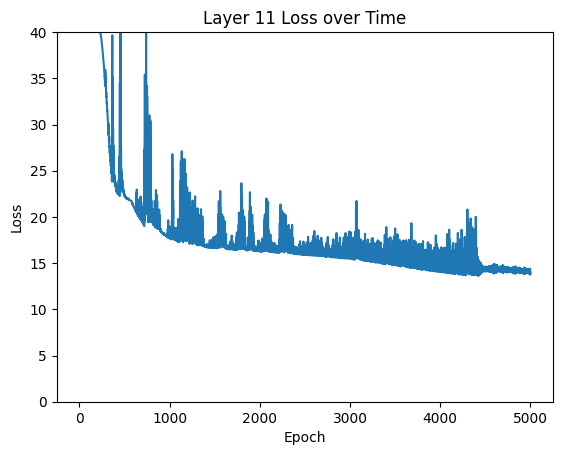

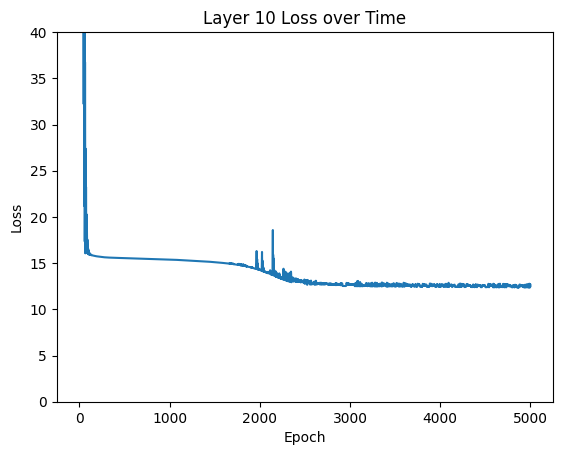

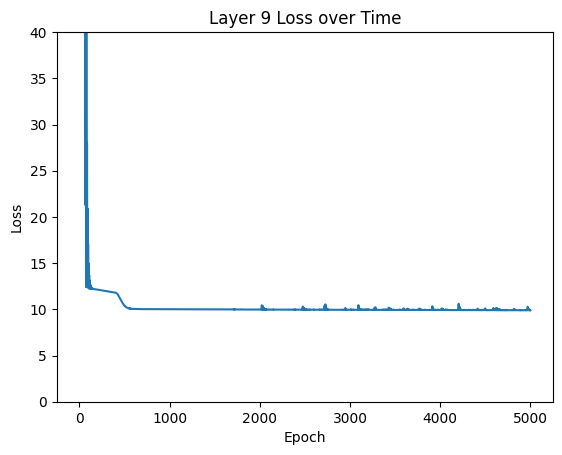

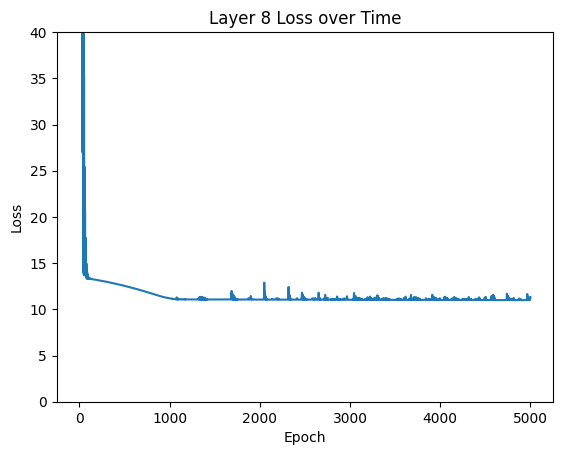

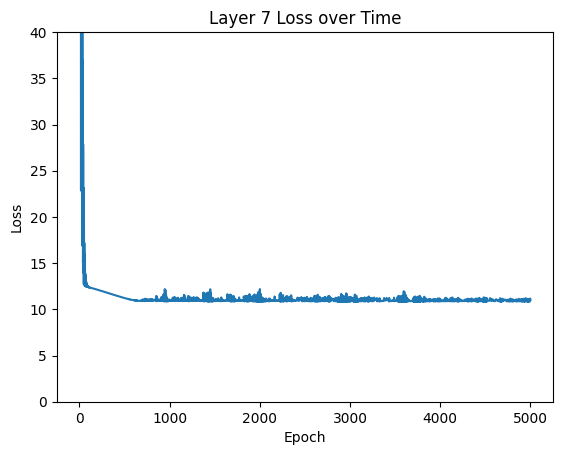

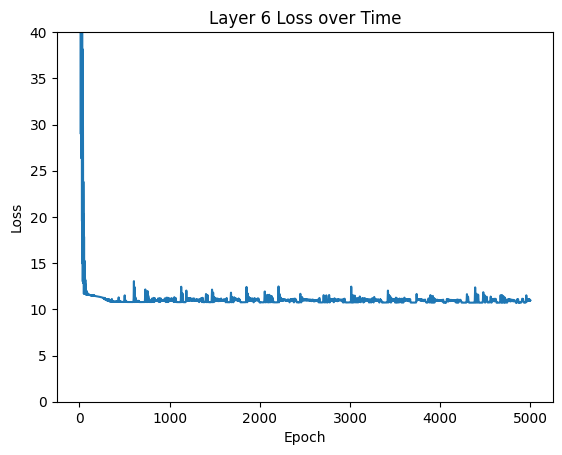

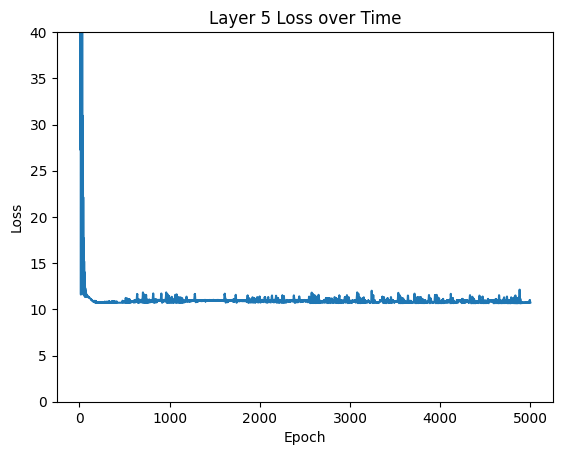

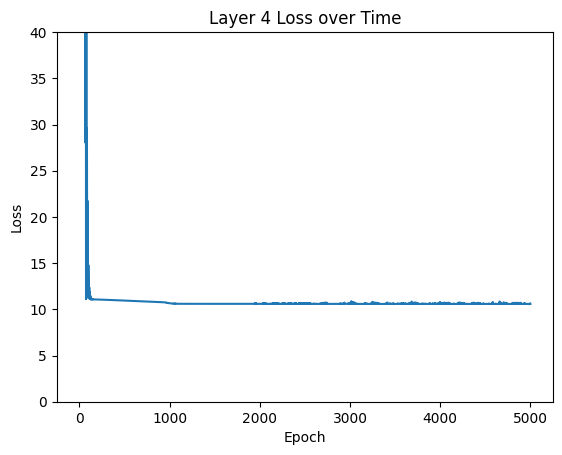

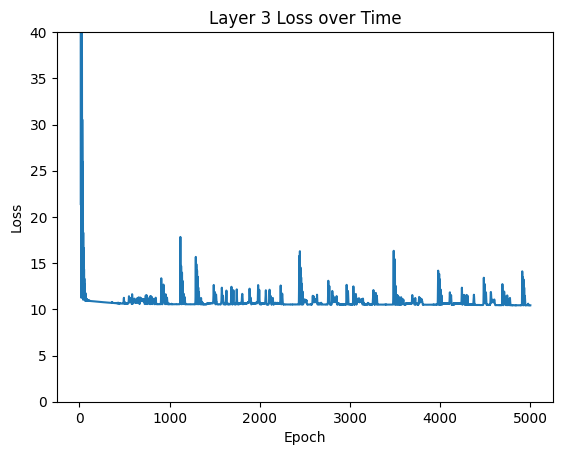

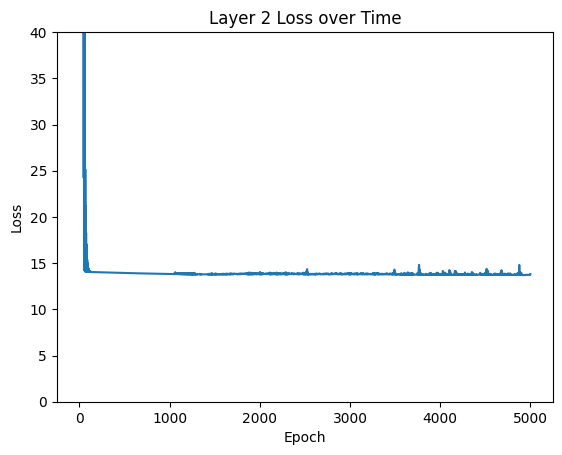

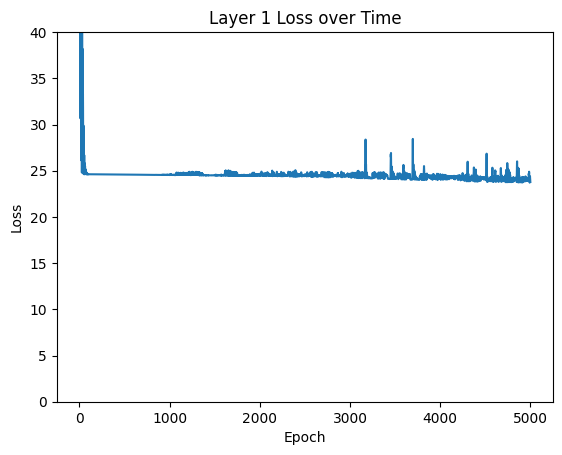

In [57]:
# plot loss over time for each layer

for i in range(num_layers):
    layer = 11 - i
    plt.plot(loss_lists[f'loss_list{layer}'])
    
    plt.title(f'Layer {layer} Loss over Time')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # limit graph to max loss of 40 (otherwise scale is decieving)
    plt.ylim(0, 40)

    plt.show()

[23.712430953979492, 13.69875717163086, 10.433653831481934, 10.571918487548828, 10.65489673614502, 10.715270042419434, 10.78681468963623, 10.98823356628418, 9.896994590759277, 12.356917381286621, 13.63707447052002]


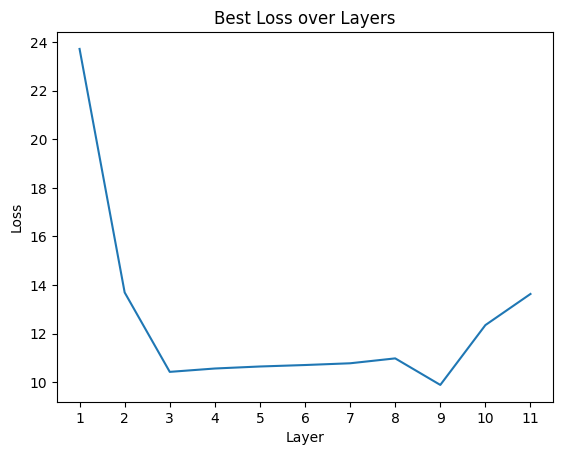

In [58]:
# plot the best loss for each layer
best_losses.reverse()
print(best_losses)
plt.plot(range(1, len(best_losses) + 1), best_losses)

plt.title("Best Loss over Layers")
plt.xlabel("Layer")
plt.ylabel("Loss")

plt.xticks(range(1, 12))

plt.show()

# Testing 

In [59]:
import matplotlib.pyplot as plt

# plot temperature predictions vs actual readings
def plot_actual_vs_pred(pred, actual):
    # specify number of samples to graph
    num_graphs = 10
    chunk_size = len(pred) // num_graphs

    # Create an appropriate number of plots
    for i in range(0, len(pred), chunk_size):
        plt.figure()
        
        plt.plot(pred[i], label='Predicted')
        plt.plot(actual[i], label='Actual')

        plt.title("Temperature: Predicted vs Actual")
        plt.xlabel("Silica Layer")
        plt.ylabel("Temperature (K)")
        
        plt.legend()
        plt.show()

Layer 11
sample_predictions: [294.59832763671875]
Layer 10
sample_predictions: [294.59832763671875, 304.91058349609375]
Layer 9
sample_predictions: [294.59832763671875, 304.91058349609375, 304.65728759765625]
Layer 8
sample_predictions: [294.59832763671875, 304.91058349609375, 304.65728759765625, 300.4007263183594]
Layer 7
sample_predictions: [294.59832763671875, 304.91058349609375, 304.65728759765625, 300.4007263183594, 303.351318359375]
Layer 6
sample_predictions: [294.59832763671875, 304.91058349609375, 304.65728759765625, 300.4007263183594, 303.351318359375, 304.45477294921875]
Layer 5
sample_predictions: [294.59832763671875, 304.91058349609375, 304.65728759765625, 300.4007263183594, 303.351318359375, 304.45477294921875, 301.8992919921875]
Layer 4
sample_predictions: [294.59832763671875, 304.91058349609375, 304.65728759765625, 300.4007263183594, 303.351318359375, 304.45477294921875, 301.8992919921875, 302.4338684082031]
Layer 3
sample_predictions: [294.59832763671875, 304.910583496

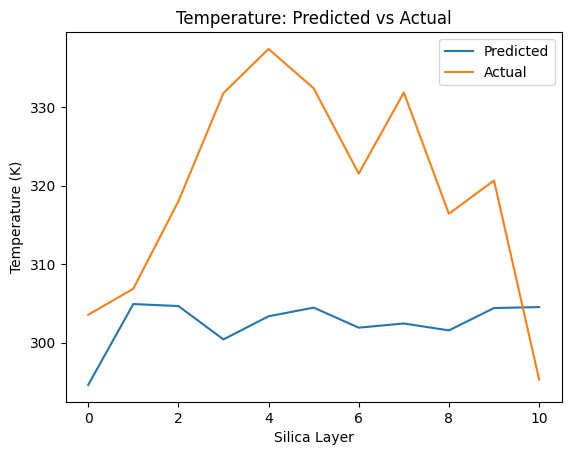

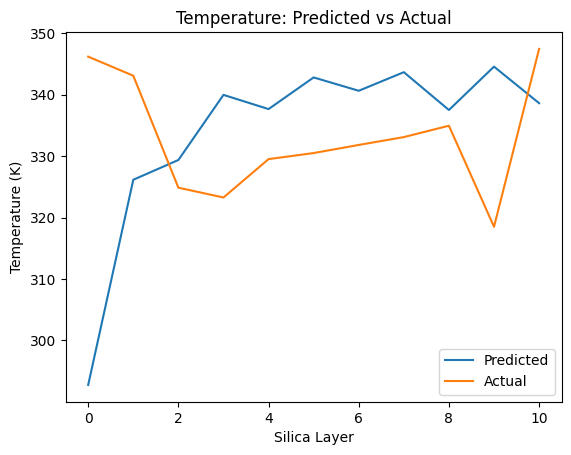

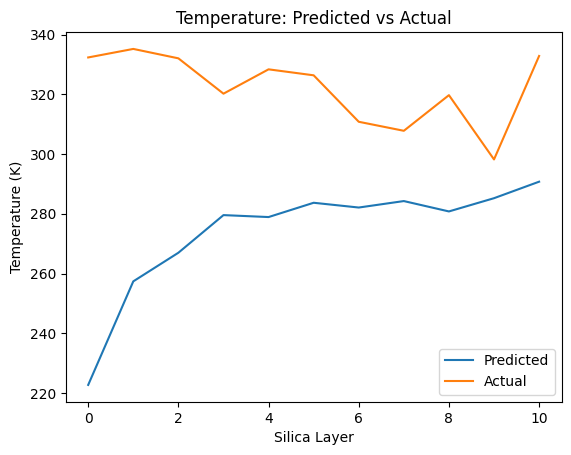

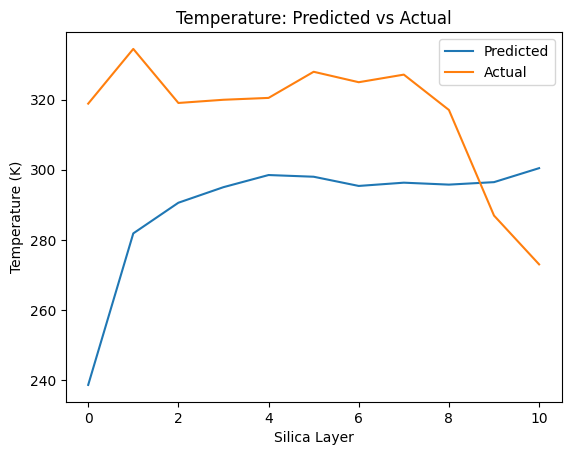

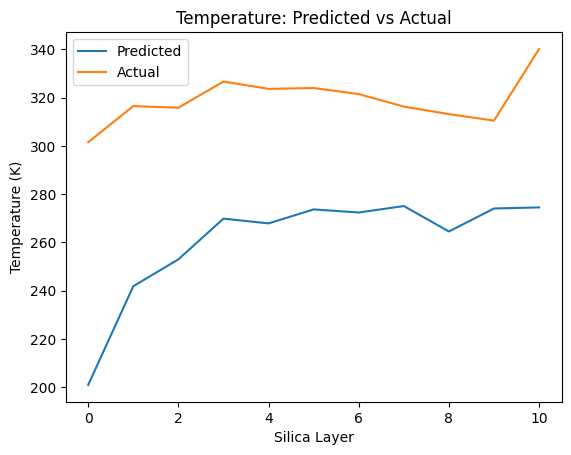

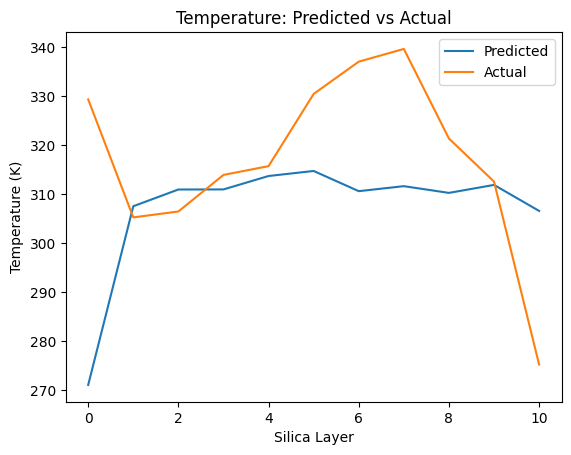

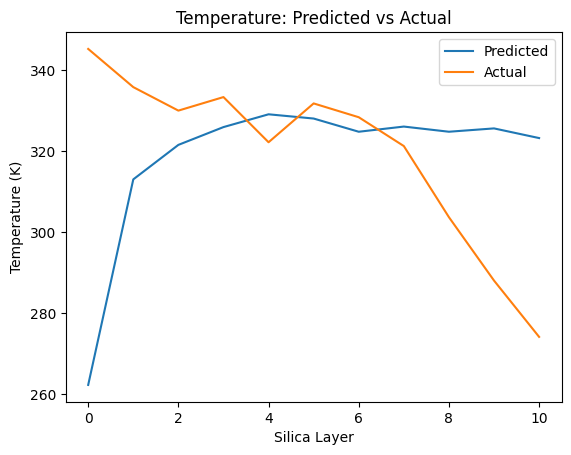

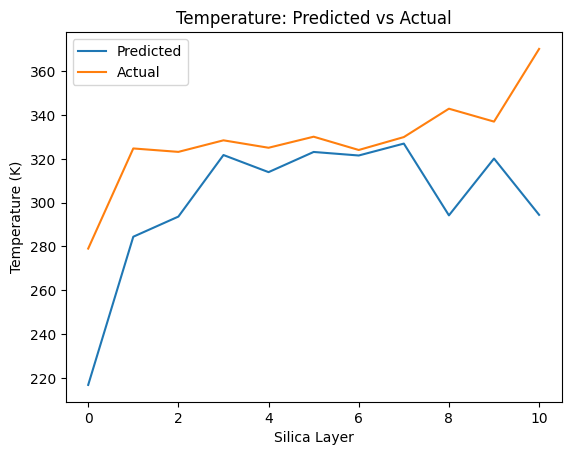

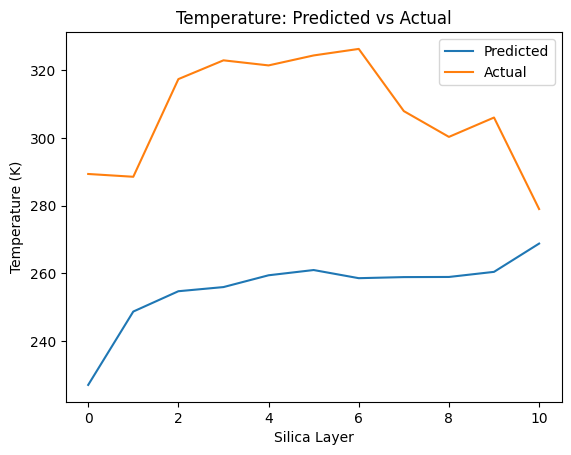

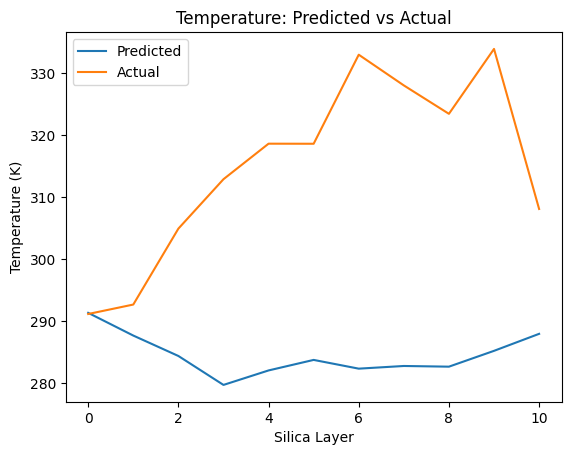

In [60]:
# convert testing data to tensor
inputs = df_to_tensor(X_test)

# define prediction list (contains sublists for each sample) 
predictions = []

with torch.no_grad():
    for sample in inputs:
        # define new sample prediction list for each sample
        sample_prediction = []

        # iterate through layers to make temperature predictions for each layer sequentially
        for i in range(num_layers):
            layer = 11 - i
            print(f'Layer {layer}')

            # add previous layer's temperature prediction to inputs
            if i > 0:
                layer_pred_reshaped = layer_pred.reshape(1, -1)
                sample_reshaped = sample.reshape(1,-1)
                sample = torch.cat([sample_reshaped, layer_pred_reshaped], dim = 1)

            # define the model corresponding to the given layer
            model = models[f'model{layer}']

            # get temperature prediction and add to sample_prediction list
            layer_pred = model(sample)
            sample_prediction.append(layer_pred.item())
            print(f'sample_predictions: {sample_prediction}')
        
        # once all layers in a given sample have been predicted, add sublist to predictions list
        predictions.append(sample_prediction)

# plot results
actual = df_to_tensor(y_test).tolist()
plot_actual_vs_pred(predictions, actual)
